# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
pd.set_option('float_format', '{:.2f}'.format)

In [3]:
raw_df = pd.read_csv('train.csv')
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
print(raw_df.info())
print(raw_df.isna().sum())
raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


In [13]:
raw_df.dropna(inplace=True)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [14]:
print(raw_df['sentiment'].value_counts(normalize=True))
raw_df.sentiment.value_counts()

sentiment
neutral    0.40
positive   0.31
negative   0.28
Name: proportion, dtype: float64


,count
sentiment,
neutral,11117
positive,8582
negative,7781


/tmp/ipython-input-2681419633.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


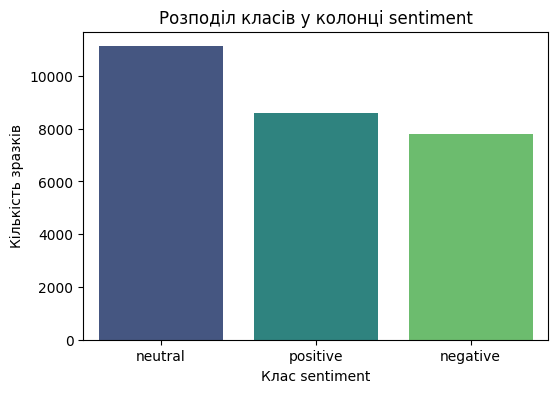

In [8]:
# Підрахунок кількості зразків у кожному класі
class_counts = raw_df['sentiment'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Розподіл класів у колонці sentiment')
plt.xlabel('Клас sentiment')
plt.ylabel('Кількість зразків')
plt.show()

In [10]:
# Remove rows with missing values
raw_df.dropna(inplace=True)

# Calculate text length
raw_df['text_length'] = raw_df['text'].apply(len)

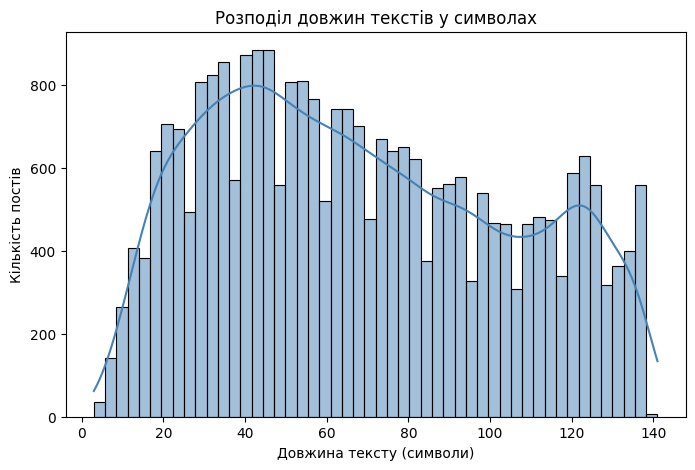

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(raw_df['text_length'], bins=50, kde=True, color='steelblue')
plt.title('Розподіл довжин текстів у символах')
plt.xlabel('Довжина тексту (символи)')
plt.ylabel('Кількість постів')
plt.show()

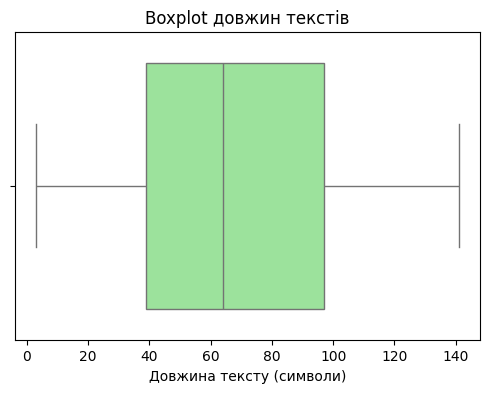

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x=raw_df['text_length'], color='lightgreen')
plt.title('Boxplot довжин текстів')
plt.xlabel('Довжина тексту (символи)')
plt.show()

In [15]:
# Виведення описової статистики
print(raw_df['text_length'].describe())

count   27480.00
mean       68.33
std        35.60
min         3.00
25%        39.00
50%        64.00
75%        97.00
max       141.00
Name: text_length, dtype: float64


**Спостереження:**

У наборі даних є три класи сентименту: neutral, positive і negative.

Найбільше твітів належить до нейтрального класу, трохи менше до позитивного та найменше до негативного.

Отже, у даних спостерігається помірний дисбаланс класів, проте він не є критичним і не повинен суттєво вплинути на результати базової моделі.

Розподіл довжин текстів показує, що більшість твітів мають коротку довжину приблизно 40 символів.
Короткі повідомлення трапляються найчастіше, тоді як довгі зустрічаються рідше.

Такий результат є очікуваним, адже твіти зазвичай лаконічні та обмежені кількістю символів.


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# -*- coding: utf-8 -*-
import re
from collections import Counter
import pandas as pd

# бібліотеки для NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [24]:
# sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# Параметри
TEXT_COL = 'text'    # назва колонки з текстом
LANG = 'english'     # мова стопслів і стемера
MIN_TOKEN_LEN = 2    # мінімальна довжина токена
COVERAGE_THRESHOLD = 0.90  # бажане покриття корупусу для вибору розміру словника

# Ініціалізація ресурсів
stop_words = set(stopwords.words(LANG))
stemmer = SnowballStemmer(LANG)

In [26]:
# Функція очищення сирого тексту
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # прибрати URL
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # прибрати mentions і email
    text = re.sub(r'@\w+|\w+@\w+\.\w+', ' ', text)
    # прибрати # але зберегти слово після #
    text = re.sub(r'#', ' ', text)
    # прибрати небажані символи, лишити літери і цифри
    text = re.sub(r'[^0-9A-Za-z\u0400-\u04FF\s]', ' ', text)  # підтримка кирилиці
    # звести до нижнього регістру і зменшити множинні пробіли
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [32]:
# Токенайзер + стопслова + стеммінг
def tokenize_and_stem(text):
    text = clean_text(text)
    tokens = text.split()
    processed = []
    for t in tokens:
        if len(t) < MIN_TOKEN_LEN:
            continue
        if t.isdigit():
            continue
        if t in stop_words:
            continue
        # стеммінг
        try:
            s = stemmer.stem(t)
        except Exception:
            s = t
        processed.append(s)
    return processed

In [41]:
# Аналіз частот токенів щоб вибрати розмір словника
def estimate_vocab_size(texts, top_n_limit=50000):
    """
    texts iterable of strings
    повертає словник частот і визначає мінімальну кількість токенів
    яка покриває COVERAGE_THRESHOLD від усіх токенів у корпусі
    """
    counter = Counter()
    doc_count = 0
    for t in texts:
        doc_count += 1
        toks = tokenize_and_stem(t)
        counter.update(toks)

    total_tokens = sum(counter.values())
    running = 0
    vocab_size_for_coverage = 0
    for i, (_, freq) in enumerate(counter.most_common(top_n_limit), 1):
        running += freq
        if running / total_tokens >= COVERAGE_THRESHOLD:
            vocab_size_for_coverage = i
            break

    if vocab_size_for_coverage == 0:
        vocab_size_for_coverage = min(len(counter), top_n_limit)

    return counter, total_tokens, vocab_size_for_coverage

In [36]:
# Приклад застосування до raw_df
def run_pipeline(raw_df):
    # 1. базова перевірка
    if TEXT_COL not in raw_df.columns:
        raise ValueError(f"DataFrame має колонку '{TEXT_COL}'")

    texts = raw_df[TEXT_COL].astype(str).tolist()

    # 2. Оцінка словника
    counter, total_tokens, vocab_size_for_coverage = estimate_vocab_size(texts)
    print(f"Загальна кількість токенів у корпусі {total_tokens}")
    print(f"Розмір словника для покриття {int(COVERAGE_THRESHOLD*100)}% токенів: {vocab_size_for_coverage}")

    # Додаткове правило: обмежимо зверху, наприклад, до 20000
    MAX_ALLOWED = 20000
    chosen_vocab_size = min(vocab_size_for_coverage, MAX_ALLOWED)
    print(f"Вибрано розмір словника {chosen_vocab_size}")

    # 3. Створюємо векторизатор і трансформуємо
    vectorizer = get_count_vectorizer(chosen_vocab_size, tokenize_and_stem)
    X = vectorizer.fit_transform(texts)  # результуюча sparse матриця

    # 4. Отримуємо таблицю найбільш частих токенів для звіту
    vocab = vectorizer.get_feature_names_out()
    # частоти зауважимо як суму по колонках
    freqs = X.sum(axis=0).A1
    top_tokens = pd.DataFrame({'token': vocab, 'freq': freqs}).sort_values('freq', ascending=False).reset_index(drop=True)

    return {
        'vectorizer': vectorizer,
        'X': X,
        'token_counter': counter,
        'top_tokens_df': top_tokens,
        'chosen_vocab_size': chosen_vocab_size
    }


if __name__ == "__main__":
    result = run_pipeline(raw_df)

Загальна кількість токенів у корпусі 188972
Розмір словника для покриття 90% токенів: 4668
Вибрано розмір словника 4668


In [39]:
    # Подивимось кілька найчастіших токенів
    print("Топ 30 токенів за частотою у отриманому векторизаторі")
    print(result['top_tokens_df'].head(30))

Топ 30 токенів за частотою у отриманому векторизаторі
     token  freq
0      day  2451
1       go  2384
2      get  1915
3     good  1600
4     work  1530
5     love  1486
6     like  1462
7    today  1155
8     time  1104
9      got  1098
10     one  1076
11     lol  1029
12   happi  1014
13    want   989
14   thank   989
15    know   981
16    miss   967
17    back   920
18  realli   916
19     see   905
20   think   884
21    feel   874
22      im   858
23   night   813
24    hope   807
25  mother   797
26    make   763
27    home   750
28     new   747
29    look   726


/tmp/ipython-input-2878239447.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='freq', y='token', data=top20, palette='viridis')


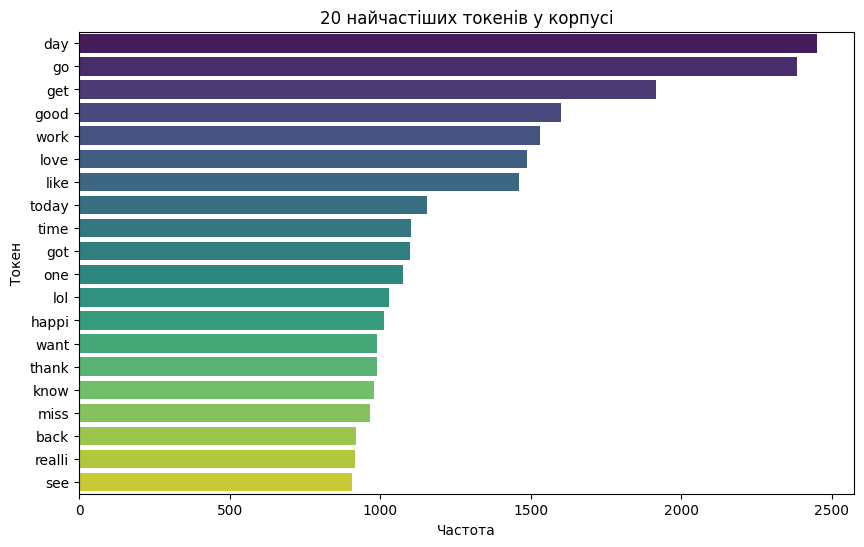

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

top20 = result['top_tokens_df'].head(20)
plt.figure(figsize=(10,6))
sns.barplot(x='freq', y='token', data=top20, palette='viridis')
plt.title('20 найчастіших токенів у корпусі')
plt.xlabel('Частота')
plt.ylabel('Токен')
plt.show()

**Спостереження:**

Після попередньої обробки текстів і токенізації корпус містить 188 972 токени, тобто стільки всього слів після очищення, видалення стопслів і стемінгу.

Для покриття 90% усього словника достатньо лише 4 668 найчастотніших слів, що свідчить про високу концентрацію лексики: більшість твітів складаються з відносно невеликої кількості часто повторюваних слів.
Аналіз найчастіших токенів показує, що в топі переважають побутові, емоційні та часові слова, характерні для соціальних мереж:
day, go, get, good, work, love, like, today, time, happi, want, thank, feel.

Це підтверджує, що корпус складається переважно з емоційно забарвлених коротких повідомлень, пов’язаних із щоденними подіями, настроєм та особистими враженнями.

Також видно, що стеммінг спрацював коректно — наприклад, слова happy → happi, really → realli, makes → make — тобто слова зведені до основи, що зменшує розмір словника без втрати змісту.
Розмір словника 4668 виглядає оптимальним для моделі bag of words: він достатньо великий, щоб охопити основну лексику, але не надмірний — це допоможе уникнути "роздутої" матриці ознак і перевищення пам’яті.

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
# Припускаємо, що X і raw_df уже є з попередніх кроків
y = raw_df['sentiment']

In [44]:
# 1. Розділення даних
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    result['X'], y, test_size=0.2, random_state=42, stratify=y
)

print("Розмір навчального набору:", X_train_bow.shape)
print("Розмір тестового набору:", X_test_bow.shape)

Розмір навчального набору: (21984, 4668)
Розмір тестового набору: (5496, 4668)


In [45]:
# 2. Створимо кілька моделей для порівняння
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

In [46]:
# 3. Навчання і оцінка
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    results[name] = acc


=== Logistic Regression ===
Accuracy: 0.6870
Classification report:
              precision    recall  f1-score   support

    negative       0.70      0.63      0.66      1556
     neutral       0.63      0.71      0.67      2223
    positive       0.76      0.71      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496


=== Decision Tree ===
Accuracy: 0.6474
Classification report:
              precision    recall  f1-score   support

    negative       0.61      0.64      0.62      1556
     neutral       0.64      0.61      0.62      2223
    positive       0.69      0.71      0.70      1717

    accuracy                           0.65      5496
   macro avg       0.65      0.65      0.65      5496
weighted avg       0.65      0.65      0.65      5496


=== Random Forest ===
Accuracy: 0.6923
Classification report:
              precision    recall  f1-score

In [47]:
# 4. Порівняння точності
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\nРезультати моделей:")
print(results_df)


Результати моделей:
                     Accuracy
Random Forest            0.69
Logistic Regression      0.69
Gradient Boosting        0.66
Decision Tree            0.65


/tmp/ipython-input-4290464799.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')


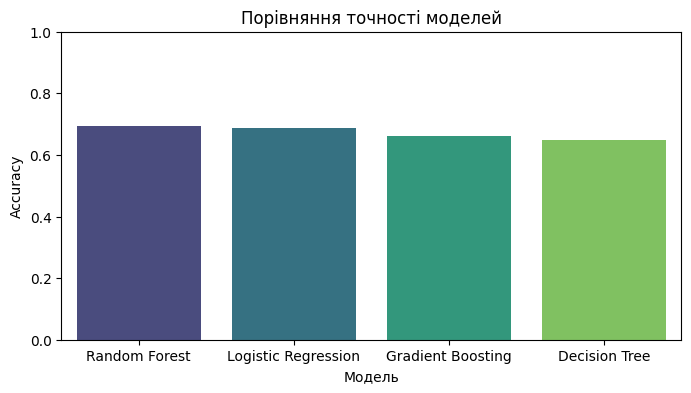

In [48]:
# 5. Візуалізація результатів
plt.figure(figsize=(8,4))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
plt.title('Порівняння точності моделей')
plt.ylabel('Accuracy')
plt.xlabel('Модель')
plt.ylim(0, 1)
plt.show()

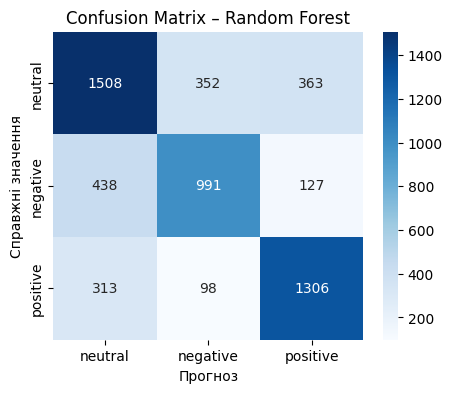

In [49]:
# 6. Для найкращої моделі покажемо матрицю плутанини
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_bow)

cm = confusion_matrix(y_test, y_pred_best, labels=y.unique())

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y.unique(), yticklabels=y.unique())
plt.title(f'Confusion Matrix – {best_model_name}')
plt.xlabel('Прогноз')
plt.ylabel('Справжні значення')
plt.show()

Спостереження:

Найкращі результати показали моделі Logistic Regression та Random Forest із точністю близько 0.69. Gradient Boosting досяг 0.66, а Decision Tree 0.65. Це свідчить, що моделі загалом непогано розрізняють позитивні, нейтральні та негативні твіти, хоча трапляються помилки між нейтральними й іншими класами.

Для базового підходу на bag of words така якість є задовільною і може слугувати відправною точкою для подальшого покращення моделі.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [52]:
# Беремо вже навчений класифікатор Logistic Regression
model = models["Logistic Regression"]
vectorizer = result['vectorizer']

# Отримуємо список слів і коефіцієнтів
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

# Для багатокласової задачі (positive, neutral, negative)
classes = model.classes_

# Формуємо таблицю коефіцієнтів
coef_df = pd.DataFrame(coefs.T, index=feature_names, columns=classes)

# Для кожного класу виберемо 10 найвпливовіших позитивних і негативних слів
for c in classes:
    print(f"\n Клас: {c}")
    top_pos = coef_df[c].sort_values(ascending=False).head(10)
    top_neg = coef_df[c].sort_values(ascending=True).head(10)
    print("Найвпливовіші слова для цього класу:")
    print(top_pos)
    print("\nСлова, що «відштовхують» прогноз від цього класу:")
    print(top_neg)


 Клас: negative
Найвпливовіші слова для цього класу:
sad        2.64
suck       2.50
sorri      2.44
bore       2.39
hate       2.33
stupid     2.12
fail       2.11
miss       2.07
worst      2.05
unfortun   1.97
Name: negative, dtype: float64

Слова, що «відштовхують» прогноз від цього класу:
glad      -2.34
awesom    -2.31
love      -2.14
beauti    -1.96
thank     -1.89
cute      -1.85
welcom    -1.74
enjoy     -1.63
amaz      -1.59
congrat   -1.54
Name: negative, dtype: float64

 Клас: neutral
Найвпливовіші слова для цього класу:
indoor        1.61
chan          1.55
otherwis      1.27
oooo          1.26
colorado      1.22
starwarsday   1.12
opinion       1.12
eu            1.10
jst           1.08
sp            1.08
Name: neutral, dtype: float64

Слова, що «відштовхують» прогноз від цього класу:
forum       -1.40
congratul   -1.34
wtf         -1.32
thrill      -1.30
incred      -1.30
product     -1.24
impati      -1.23
proud       -1.20
truli       -1.18
nut         -1.15
Name: neu

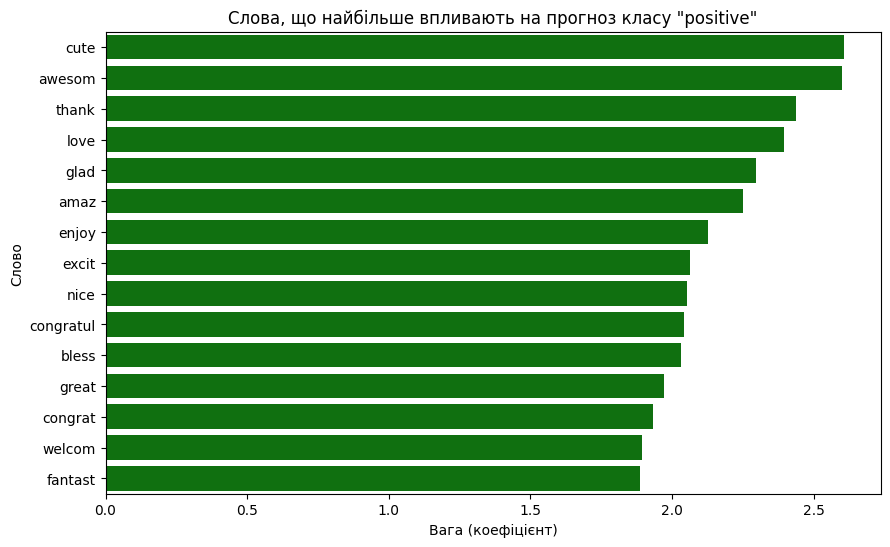

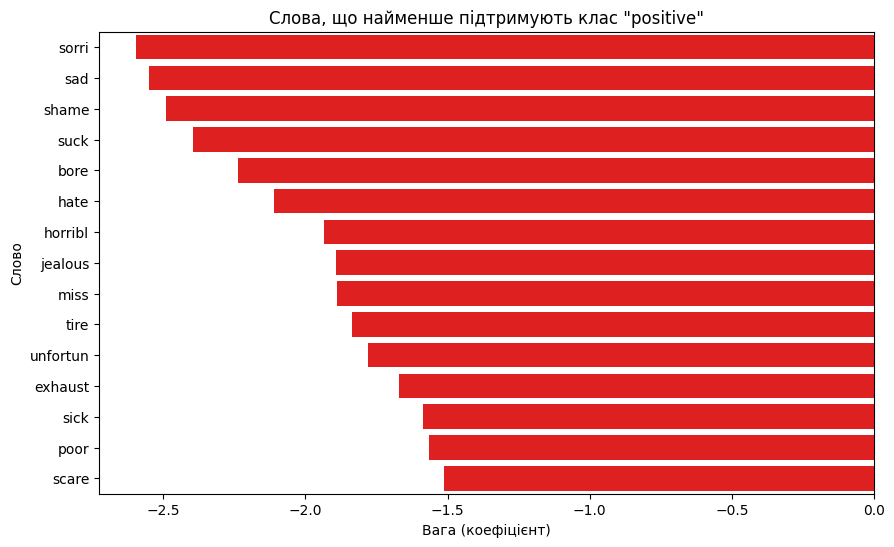

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Візуалізація для, наприклад, позитивного класу
target_class = 'positive'
top_features = coef_df[target_class].sort_values(ascending=False).head(15)
bottom_features = coef_df[target_class].sort_values(ascending=True).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, color='green')
plt.title(f'Слова, що найбільше впливають на прогноз класу "{target_class}"')
plt.xlabel('Вага (коефіцієнт)')
plt.ylabel('Слово')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=bottom_features.values, y=bottom_features.index, color='red')
plt.title(f'Слова, що найменше підтримують клас "{target_class}"')
plt.xlabel('Вага (коефіцієнт)')
plt.ylabel('Слово')
plt.show()

Спостереження:

Аналіз коефіцієнтів моделі Logistic Regression показав, які слова найбільше впливають на прогноз сентименту.

Для негативного класу найбільш впливові слова такі як sad, suck, sorri, bore, hate, stupid, fail, miss, worst, unfortun, що логічно, адже вони передають негативні емоції. Слова на кшталт glad, love, thank, cute, awesom зменшують ймовірність цього класу.

Для позитивного класу сильний вплив мають слова cute, awesom, thank, love, glad, amaz, enjoy, excit, nice, congratul, а слова негативного забарвлення зменшують ймовірність позитивного сентименту.

Для нейтрального класу важливі слова більш нейтральні або інформаційні, наприклад indoor, chan, otherwis, colorado, starwarsday, а слова з емоційним забарвленням, як forum, wtf, thrill, incred, відштовхують прогноз від цього класу.

В цілому модель робить осмислені лінгвістичні узагальнення: позитивні слова підтримують позитивний клас, негативні — негативний, нейтральні слова допомагають розпізнавати нейтральні тексти, що відповідає очікуванням і робить модель інтерпретованою.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [54]:
# Тренувальні і тестові тексти у вигляді списку
train_texts = raw_df.loc[y_train.index, 'text'].astype(str).tolist()
test_texts = raw_df.loc[y_test.index, 'text'].astype(str).tolist()

In [55]:
# Створюємо TF-IDF векторизатор з власним препроцесором і токенайзером
tfidf_vect = TfidfVectorizer(
    tokenizer=lambda s: tokenize_and_stem(s),
    preprocessor=None,
    lowercase=False,
    max_features=result['chosen_vocab_size'],  # беремо той самий розмір словника, що і для BoW
    token_pattern=None
)

In [56]:
# Фітимо на тренувальних даних
X_train_tfidf = tfidf_vect.fit_transform(train_texts)
X_test_tfidf = tfidf_vect.transform(test_texts)

In [57]:
# Навчання Logistic Regression
clf_tfidf = LogisticRegression(max_iter=1000, random_state=42)
clf_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [58]:
# Прогноз і метрики
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_tfidf)
f1_macro = f1_score(y_test, y_pred_tfidf, average='macro')

In [59]:
print(f"TF-IDF Logistic Regression Accuracy: {accuracy:.3f}, F1_macro: {f1_macro:.3f}")
print(classification_report(y_test, y_pred_tfidf))

TF-IDF Logistic Regression Accuracy: 0.691, F1_macro: 0.691
              precision    recall  f1-score   support

    negative       0.72      0.60      0.66      1556
     neutral       0.63      0.75      0.68      2223
    positive       0.78      0.70      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



In [61]:
# Коефіцієнти TF-IDF моделі
feature_names_tfidf = tfidf_vect.get_feature_names_out()
coefs_tfidf = clf_tfidf.coef_

classes = clf_tfidf.classes_
coef_df_tfidf = pd.DataFrame(coefs_tfidf.T, index=feature_names_tfidf, columns=classes)

for c in classes:
    print(f"\n Клас: {c} (TF-IDF)")
    top_pos = coef_df_tfidf[c].sort_values(ascending=False).head(10)
    top_neg = coef_df_tfidf[c].sort_values(ascending=True).head(10)
    print("Найвпливовіші слова:")
    print(top_pos)
    print("\nСлова, що зменшують ймовірність класу:")
    print(top_neg)


 Клас: negative (TF-IDF)
Найвпливовіші слова:
sad      5.22
miss     4.75
sorri    4.60
suck     4.33
hate     4.30
bore     3.93
fail     3.65
hurt     3.46
stupid   3.38
poor     3.31
Name: negative, dtype: float64

Слова, що зменшують ймовірність класу:
love     -4.99
thank    -3.73
awesom   -3.36
hope     -3.29
glad     -3.20
great    -2.81
nice     -2.47
enjoy    -2.29
amaz     -2.28
cute     -2.26
Name: negative, dtype: float64

 Клас: neutral (TF-IDF)
Найвпливовіші слова:
indoor        1.28
guitar        1.27
except        1.14
grade         1.00
knock         0.98
2moro         0.98
insur         0.97
otherwis      0.95
starwarsday   0.95
click         0.95
Name: neutral, dtype: float64

Слова, що зменшують ймовірність класу:
happi     -2.67
good      -2.54
fail      -1.99
thank     -1.90
stupid    -1.89
excit     -1.86
perfect   -1.83
funni     -1.80
hurt      -1.78
amaz      -1.76
Name: neutral, dtype: float64

 Клас: positive (TF-IDF)
Найвпливовіші слова:
love     6.57
than

Спостереження:

Модель Logistic Regression на TF-IDF досягла точності 0.69 та F1_macro 0.69.

Позитивний клас розпізнається найкраще, негативний найскладніше, нейтральний посередньо.

Найважливіші слова для прогнозу відповідають сенсу класів: позитивні слова підтримують позитивний клас, негативні — негативний, нейтральні слова допомагають визначати neutral.

TF-IDF трохи покращує точність порівняно з BoW і краще зважує рідкісні, але значущі слова, тому його доцільно використовувати для фінальної моделі.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [62]:
# Порівняння прогнозу та істинного класу
errors = raw_df.loc[y_test.index]
errors = errors.copy()
errors['y_true'] = y_test
errors['y_pred'] = y_pred_tfidf
errors_misclassified = errors[errors['y_true'] != errors['y_pred']]

# Подивимось кілька прикладів
errors_misclassified[['text','y_true','y_pred']].head(10)

,text,y_true,y_pred
23414,Reading and taking notes but undertanding none...,negative,neutral
4127,Hoping that this will just heal on it`s own be...,neutral,negative
4832,yum. Do you do home delivery,positive,neutral
19360,Having a wonderful piece of cake for lunch - w...,positive,neutral
24967,"Don`t worry, you`ll get your stamina back soo...",positive,neutral
10652,shack idol today(: can`t wait. it`s gonna be f...,neutral,negative
17484,"Awww, *hugs* I wish I could help.",negative,positive
7936,2 hours after teleconference. but can`t go bac...,negative,neutral
10247,Youtube isn`t working...and I wanted to watch ...,negative,neutral
3704,**** Frat - that`s too bad... Should be a go...,neutral,positive


In [65]:
# Aggregates for error patterns
errors["len"] = errors["text"].str.len()
agg = (
    errors
    .assign(bucket=pd.cut(errors["len"], bins=[0,30,60,90,120,999], include_lowest=True))
    .groupby("bucket", observed=True)["y_true"].count() # Count occurrences in each bucket
    .rename("count")
)
print(agg)
print("\nРозподіл справжніх настроїв у помилкахv:")
print(errors["y_true"].value_counts())
print("\nПрогнозований розподіл настроїв у помилках:")
print(errors["y_pred"].value_counts())

bucket
(-0.001, 30.0]     912
(30.0, 60.0]      1688
(60.0, 90.0]      1315
(90.0, 120.0]      977
(120.0, 999.0]     604
Name: count, dtype: int64

Розподіл справжніх настроїв у помилкахv:
y_true
neutral     2223
positive    1717
negative    1556
Name: count, dtype: int64

Прогнозований розподіл настроїв у помилках:
y_pred
neutral     2645
positive    1543
negative    1308
Name: count, dtype: int64


**Спостереження:**

Більшість помилок припадає на тексти середньої довжини від 30 до 90 символів, що є типовим для твітів.

Серед помилок переважають нейтральні тексти, які модель часто плутає з позитивними або негативними.

Також видно, що модель схильна трохи переоцінювати нейтральний клас і занижувати негативний, прогнозуючи менше негативних прикладів, ніж їх фактично є.

Це вказує на необхідність додаткового опрацювання нейтральних та коротких текстів для підвищення точності.


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model